# Reconstructing Temporal connections of poisson data, rec errors, correlations of 10 runs

In [1]:
import matplotlib.pyplot as plt
import torch

from data.poisson_data_v import PoissonTimeShiftedData
from utils.funcs import get_reconstruction_mean_pairwise_correlations
from boltzmann_machines.cp_rtrbm import RTRBM
from boltzmann_machines.cp_rbm import RBM
from tqdm import tqdm

Simulation constants

In [11]:
n_v = 60
n_h = 3
T = 50
n_batches = 500
n_train_batches = 400
n_test_batches = 100
delay = 1
temporal_connections = torch.tensor([
    [0, -1, 1],
    [1, 0, -1],
    [-1, 1, 0]
]).float() * 2
frequency_range = [5, 10]
phase_range = [0, torch.pi]
amplitude_range = [0.4, 0.5]
n_runs = 10
plot_results = True

run 1


100%|██████████| 200/200 [15:11<00:00,  4.56s/it]


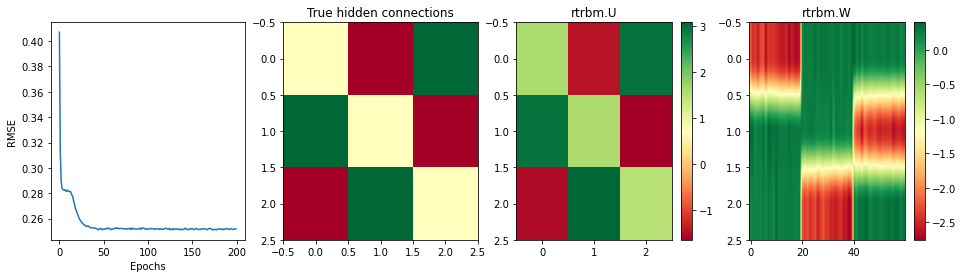

100%|██████████| 200/200 [02:21<00:00,  1.42it/s]


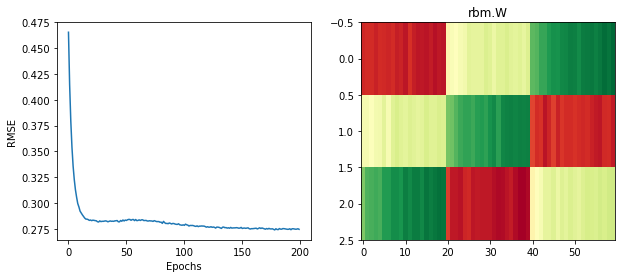

100%|██████████| 100/100 [00:35<00:00,  2.79it/s]


run 2


100%|██████████| 200/200 [15:08<00:00,  4.54s/it]


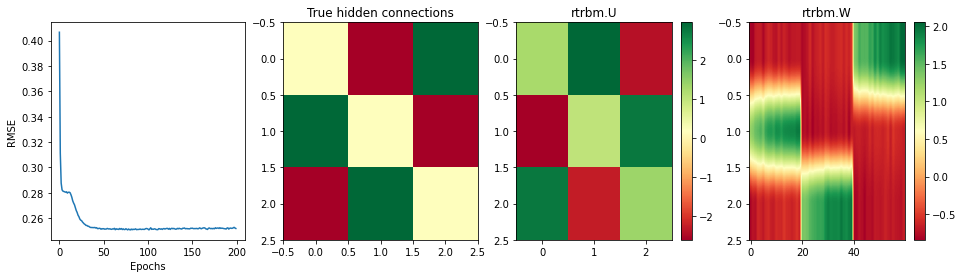

100%|██████████| 200/200 [02:07<00:00,  1.57it/s]


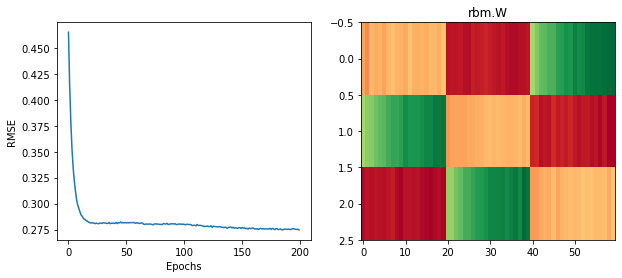

100%|██████████| 100/100 [00:35<00:00,  2.80it/s]


run 3


100%|██████████| 200/200 [14:59<00:00,  4.50s/it]


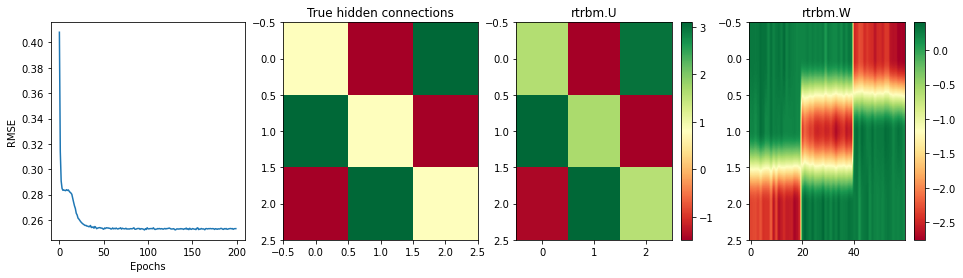

100%|██████████| 200/200 [02:07<00:00,  1.57it/s]


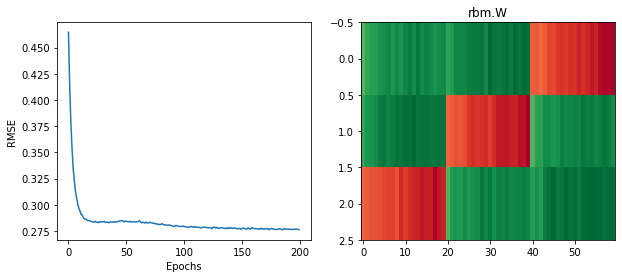

100%|██████████| 100/100 [00:35<00:00,  2.79it/s]


run 4


100%|██████████| 200/200 [14:44<00:00,  4.42s/it]


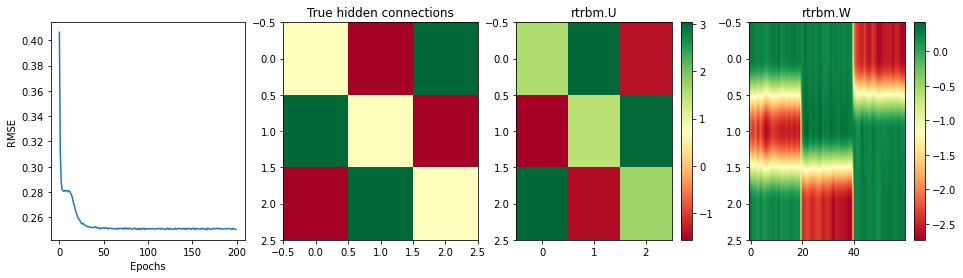

100%|██████████| 200/200 [02:09<00:00,  1.55it/s]


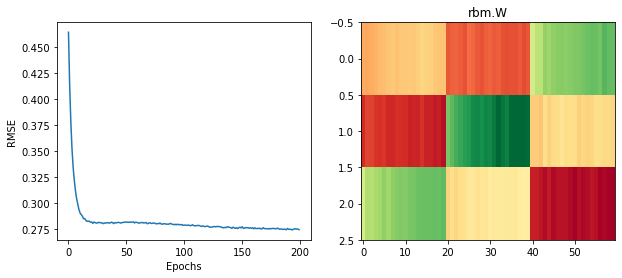

100%|██████████| 100/100 [00:35<00:00,  2.78it/s]


run 5


100%|██████████| 200/200 [15:07<00:00,  4.54s/it]


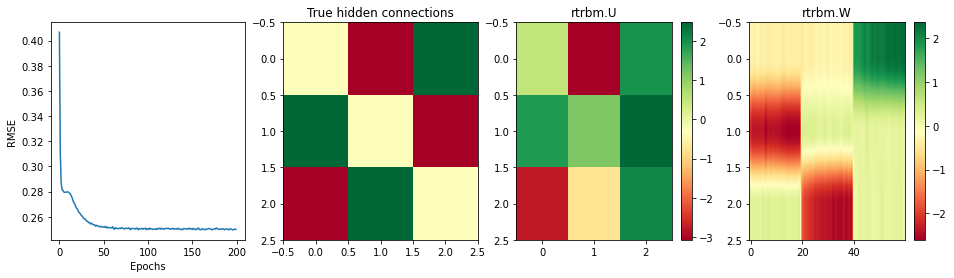

100%|██████████| 200/200 [02:08<00:00,  1.56it/s]


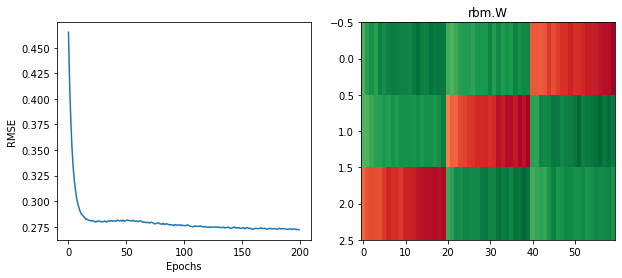

100%|██████████| 100/100 [00:35<00:00,  2.81it/s]


run 6


100%|██████████| 200/200 [14:57<00:00,  4.49s/it]


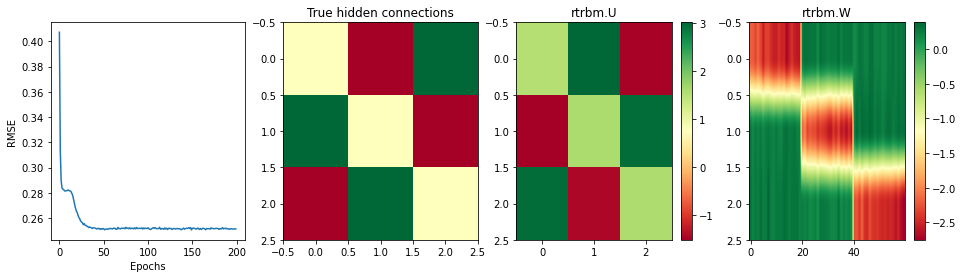

100%|██████████| 200/200 [02:07<00:00,  1.56it/s]


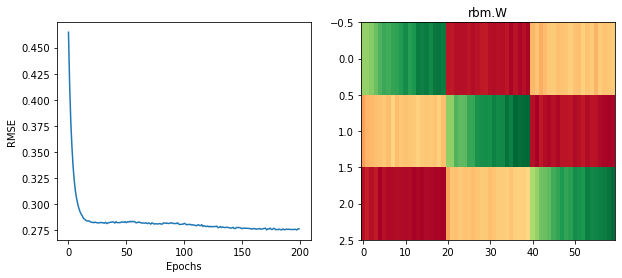

100%|██████████| 100/100 [00:35<00:00,  2.80it/s]


run 7


100%|██████████| 200/200 [15:07<00:00,  4.54s/it]


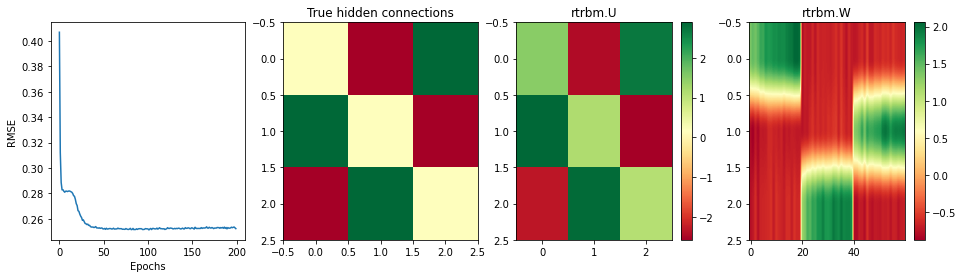

100%|██████████| 200/200 [02:07<00:00,  1.57it/s]


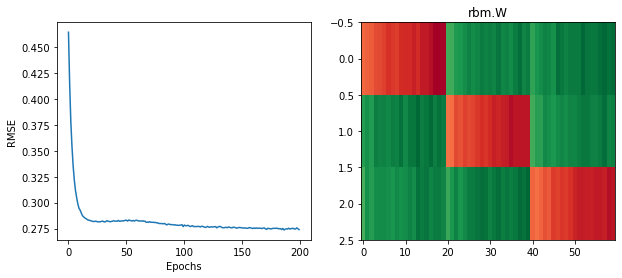

100%|██████████| 100/100 [00:35<00:00,  2.78it/s]


run 8


100%|██████████| 200/200 [15:06<00:00,  4.53s/it]


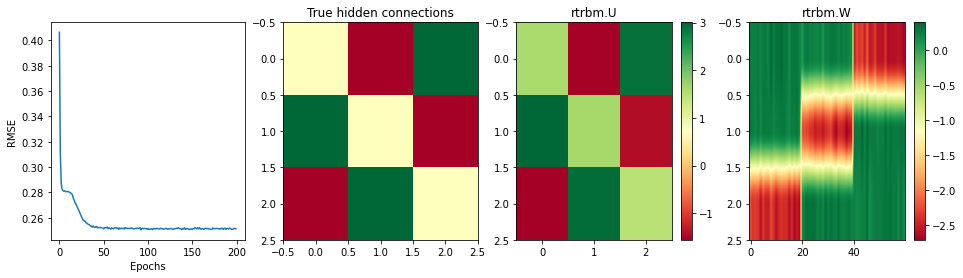

100%|██████████| 200/200 [02:52<00:00,  1.16it/s]


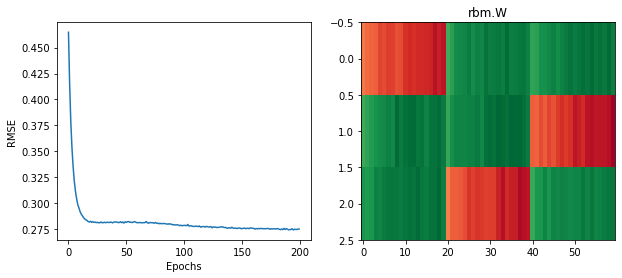

100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


run 9


100%|██████████| 200/200 [18:23<00:00,  5.52s/it]


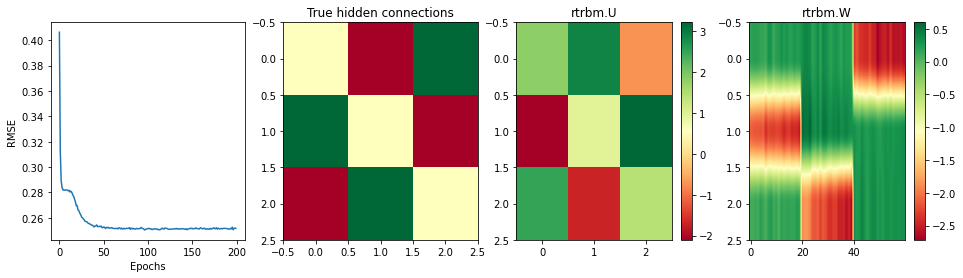

100%|██████████| 200/200 [02:43<00:00,  1.23it/s]


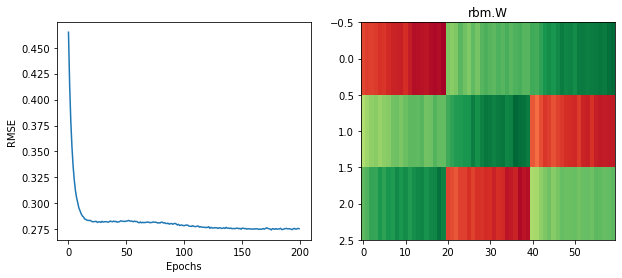

100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


run 10


100%|██████████| 200/200 [17:10<00:00,  5.15s/it]


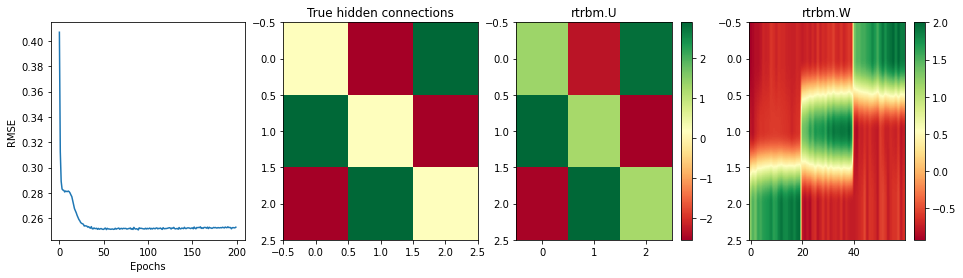

100%|██████████| 200/200 [02:22<00:00,  1.40it/s]


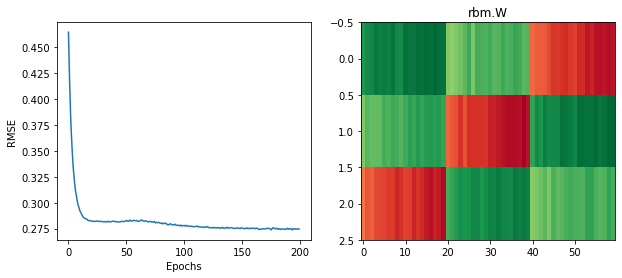

100%|██████████| 100/100 [00:41<00:00,  2.38it/s]


In [12]:
rbm_list, rtrbm_list, train_list, test_list = [], [], [], []

rec_errors_rtrbm = torch.zeros(n_runs)
rec_corr_rtrbm = torch.zeros(n_runs)
mean_corr_rtrbm = torch.zeros(n_runs)
pw_corr_rtrbm = torch.zeros(n_runs)

rec_errors_rbm = torch.zeros(n_runs)
rec_corr_rbm = torch.zeros(n_runs)
mean_corr_rbm = torch.zeros(n_runs)
pw_corr_rbm = torch.zeros(n_runs)

for i in range(n_runs):
    print('run %d' % (i+1))

    # create data
    gaus = PoissonTimeShiftedData(
        neurons_per_population=n_v//n_h, n_populations=n_h, n_batches=n_batches, time_steps_per_batch=T,
        fr_mode='gaussian', delay=delay, temporal_connections=temporal_connections, norm=1,
        frequency_range=frequency_range, amplitude_range=amplitude_range, phase_range=phase_range
    )

    # split in train and test set
    train, test = gaus.data[..., :n_train_batches], gaus.data[..., n_train_batches:]

    # train rtrbm
    rtrbm = RTRBM(train, N_H=n_h, device="cpu")
    rtrbm.learn(batch_size=10, n_epochs=200, max_lr=1e-3, min_lr=8e-4, lr_schedule='geometric_decay', CDk=10, mom=0.6, wc=0.0002, sp=0, x=1)

    rtrbm_list += [rtrbm]
    train_list += [train]
    test_list += [test]

    # plot results
    if plot_results:
        fig, ax = plt.subplots(1, 4, figsize=(16, 4))
        ax[0].plot(rtrbm.errors)
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('RMSE')
        ax[1].imshow(gaus.temporal_connections, aspect='auto', cmap=plt.get_cmap('RdYlGn'))
        ax[1].set_title('True hidden connections')
        cm = ax[2].imshow(rtrbm.U, aspect='auto', cmap=plt.get_cmap('RdYlGn'))
        fig.colorbar(cm, ax=ax[2])
        ax[2].set_title('rtrbm.U')
        cm = ax[3].imshow(rtrbm.W, aspect='auto', cmap=plt.get_cmap('RdYlGn'))
        fig.colorbar(cm, ax=ax[3])
        ax[3].set_title('rtrbm.W')

        plt.show()

    # infer over all test batches
    vs = torch.zeros(n_v, T, n_test_batches)
    for batch in range(n_test_batches):
        vs[:, :, batch], _ = rtrbm.infer(test[:, :T//2, batch], mode=1, pre_gibbs_k=100, gibbs_k=100, disable_tqdm=True)

    # save rec error and correlations
    rec_errors_rtrbm[i] = torch.mean((vs[:, T//2:, :] - test[:, T//2:, :])**2)
    rec_corr_rtrbm[i], mean_corr_rtrbm[i], pw_corr_rtrbm[i] = get_reconstruction_mean_pairwise_correlations(test[:, T//2:, :], vs[:, T//2:, :])

    # save rtrbm temporarily in list
    rtrbm_list += [rtrbm]

    # train rbm
    rbm = RBM(train, N_H=n_h, device='cpu', debug_mode=False)
    rbm.learn(n_epochs=200, batch_size=40, max_lr=1e-3, min_lr=8e-4, lr_schedule='geometric_decay', CDk=10, mom=0.6, wc=0.0002)

    # plot results
    if plot_results:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].plot(rbm.errors)
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('RMSE')
        axes[1].imshow(rbm.W, aspect='auto', cmap=plt.get_cmap('RdYlGn'))
        axes[1].set_title('rbm.W')
        plt.show()

    # infer
    vs = torch.zeros(n_v, T, n_test_batches)
    for batch in tqdm(range(n_test_batches)):
        vs[:, :, batch], _ = rbm.sample(test[:, 0, batch], mode=1, pre_gibbs_k=100, gibbs_k=100, disable_tqdm=True)

    rec_errors_rbm[i] = torch.mean((vs[:, :T//2, :] - test[:, :T//2, :])**2)
    rec_corr_rbm[i], mean_corr_rbm[i], pw_corr_rbm[i] = get_reconstruction_mean_pairwise_correlations(test[:, T//2:, :], vs[:, T//2:, :])

    rbm_list += [rbm]

In [16]:
for i, (rtrbm, test) in tqdm(enumerate(zip(rtrbm_list, test_list))):
    # infer over all test batches
    vs = torch.zeros(n_v, T, n_test_batches)
    for batch in range(n_test_batches):
        vs[:, :, batch], _ = rtrbm.infer(test[:, :T//2, batch], mode=1, pre_gibbs_k=100, gibbs_k=100, disable_tqdm=True)

    # save rec error and correlations
    rec_errors_rtrbm[i] = torch.mean((vs[:, T//2:, :] - test[:, T//2:, :])**2)

10it [06:04, 36.44s/it]


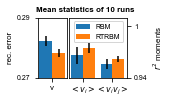

In [65]:
plt.rcParams["font.family"] = "Arial"

fig, axes = plt.subplots(1, 2, figsize=(2.23, 1.3), gridspec_kw={'width_ratios': [1, 2]})

ax = axes[0]
ax.bar(.8, torch.mean(rec_errors_rbm), yerr=torch.std(rec_errors_rbm), width=.4)
ax.bar(1.2, torch.mean(rec_errors_rtrbm), yerr=torch.std(rec_errors_rtrbm), width=.4)
ax.set_ylabel('rec. error', fontsize=8)
ax.set_ylim([.27, .29])
ax.set_xticks([1])
ax.set_xticklabels('$v_{i, [t]}$', fontsize=8)
ax.set_yticks([.27, .29])
ax.set_yticklabels([.27, .29], fontsize=7)

ax = axes[1]
ax.bar(torch.arange(2) - .2, [torch.mean(mean_corr_rbm**2), torch.mean(pw_corr_rbm**2)], yerr=[torch.std(mean_corr_rbm**2), torch.std(pw_corr_rbm**2)], label='RBM', width=.4)
ax.bar(torch.arange(2) + .2, [torch.mean(mean_corr_rtrbm**2), torch.mean(pw_corr_rtrbm**2)], yerr=[torch.std(mean_corr_rtrbm**2), torch.std(pw_corr_rtrbm**2)], label='RTRBM', width=.4)
ax.set_ylim([.94, 1.01])
ax.set_ylabel('$r^2$ moments', fontsize=8)
ax.legend(fontsize=7)
ax.set_xticks([0, 1])
ax.set_xticklabels(['$<v_i>$', '$<v_iv_j>$'], fontsize=8)
ax.set_yticks([.94, 1])
ax.set_yticklabels([.94, 1], fontsize=7)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

fig.suptitle('Mean statistics of 10 runs', fontsize=8, fontweight='bold')

plt.tight_layout(pad=0.2, h_pad=0, w_pad=0.2)
plt.savefig('../../figures/Paper Figures/Figure 2/summary.png', dpi=1000)

plt.show()

run 1


100%|██████████| 200/200 [02:39<00:00,  1.26it/s]


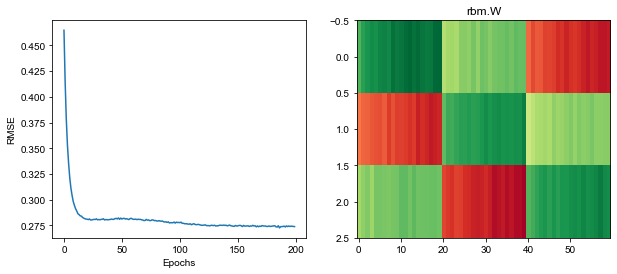

run 2


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


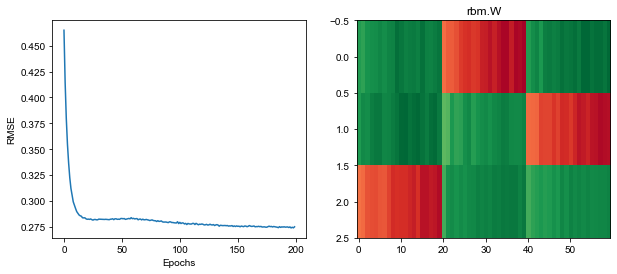

run 3


100%|██████████| 200/200 [02:25<00:00,  1.37it/s]


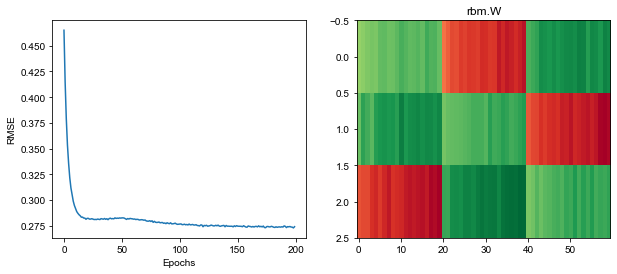

run 4


100%|██████████| 200/200 [02:25<00:00,  1.38it/s]


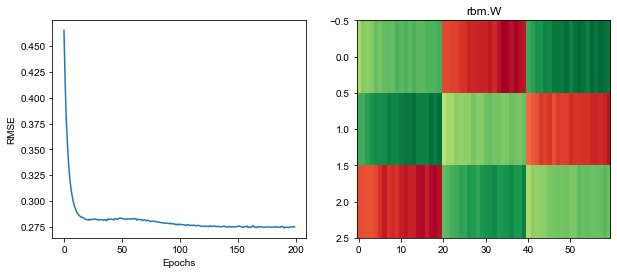

run 5


100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


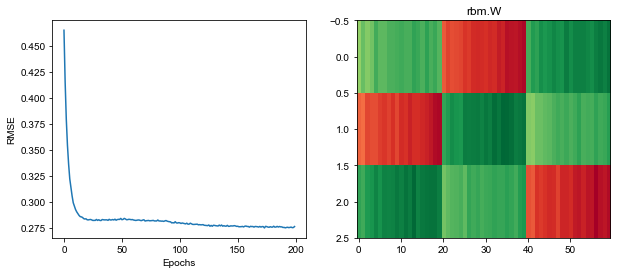

run 6


100%|██████████| 200/200 [02:33<00:00,  1.30it/s]


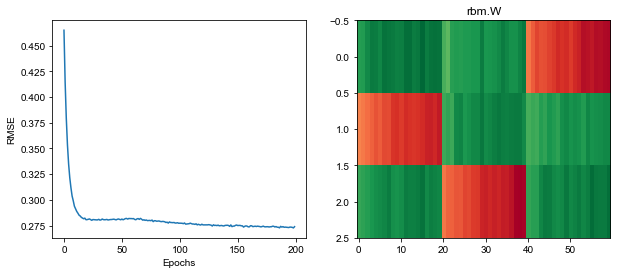

run 7


100%|██████████| 200/200 [02:18<00:00,  1.45it/s]


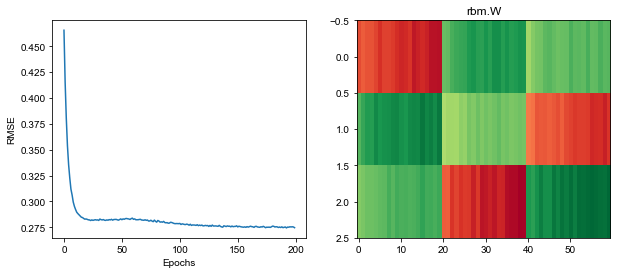

run 8


100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


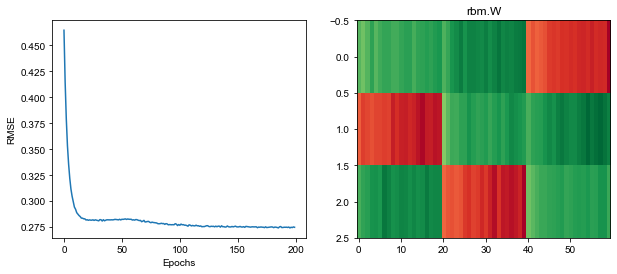

run 9


100%|██████████| 200/200 [02:13<00:00,  1.49it/s]


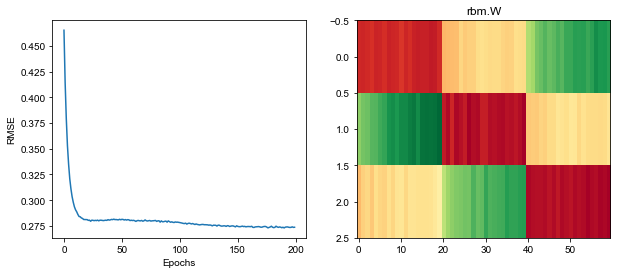

run 10


100%|██████████| 200/200 [02:15<00:00,  1.48it/s]


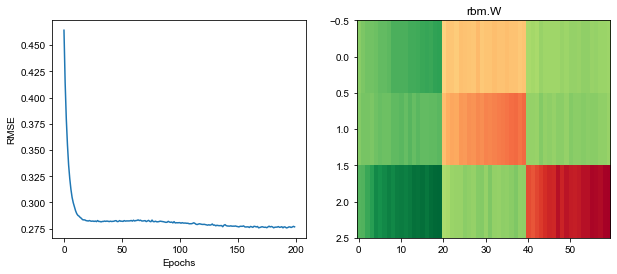

In [86]:
rbm_list = []

for i in range(n_runs):
    print('run %d' % (i+1))

    # create data
    gaus = PoissonTimeShiftedData(
        neurons_per_population=n_v//n_h, n_populations=n_h, n_batches=n_batches, time_steps_per_batch=T,
        fr_mode='gaussian', delay=delay, temporal_connections=temporal_connections, norm=1,
        frequency_range=frequency_range, amplitude_range=amplitude_range, phase_range=phase_range
    )

    # split in train and test set
    train, test = gaus.data[..., :n_train_batches], gaus.data[..., n_train_batches:]

    # train rbm
    rbm = RBM(train, N_H=n_h, device='cpu', debug_mode=False)
    rbm.learn(n_epochs=200, batch_size=40, max_lr=1e-3, min_lr=8e-4, lr_schedule='geometric_decay', CDk=10, mom=0.6, wc=0.0002)

    # plot results
    if plot_results:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].plot(rbm.errors)
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('RMSE')
        axes[1].imshow(rbm.W, aspect='auto', cmap=plt.get_cmap('RdYlGn'))
        axes[1].set_title('rbm.W')
        plt.show()

    rbm_list += [rbm]

In [6]:
rtrbm_list = torch.load('rtrbm_list.pt')
rbm_list = torch.load('rbm_list.pt')

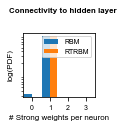

In [37]:
plt.rcParams["font.family"] = "Arial"

n_runs=10

# av_conn_rtrbm = torch.zeros(60, n_runs)
# av_conn_rbm = torch.zeros(60, n_runs)

# for i, (rbm, rtrbm) in enumerate(zip(rbm_list, rtrbm_list)):
# av_conn_rtrbm[:, i] = torch.sum(rtrbm.W > .5*torch.std(rtrbm.W), 0)
# av_conn_rbm[:, i] = torch.sum(rbm.W > .5*torch.std(rbm.W), 0)

rtrbm = rtrbm_list[19]
rbm = rbm_list[8]

av_conn_rtrbm = torch.sum(rtrbm.W > .5*torch.std(rtrbm.W), 0)
av_conn_rbm = torch.sum(rbm.W > .5*torch.std(rbm.W), 0)

n_conn_rbm, counts_rbm = torch.unique(av_conn_rbm, return_counts=True)
n_conn_rtrbm, counts_rtrbm = torch.unique(av_conn_rtrbm, return_counts=True)

fig, ax = plt.subplots(figsize=(2.23, 2))
ax.bar(n_conn_rbm - .2, counts_rbm / torch.sum(counts_rbm), width=.4, label='RBM')
ax.bar(n_conn_rtrbm + .2, counts_rtrbm / torch.sum(counts_rtrbm), width=.4, label='RTRBM')
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([0, 1, 2, 3], fontsize=7)
ax.set_xlim([-.5, 3.5])
ax.set_ylabel('log(PDF)', fontsize=8)
ax.set_yscale('log')
fig.suptitle('Connectivity to hidden layer', fontsize=8, fontweight='bold')
ax.set_xlabel('# Strong weights per neuron', fontsize=8)
ax.set_yticks([])
ax.set_box_aspect()

fig.legend(fontsize=7, loc='upper right', bbox_to_anchor=(.7, .8))
plt.tight_layout(pad=.2, h_pad=.2, w_pad=.2)
plt.subplots_adjust(left=0.25, bottom=0.35, right=0.7, top=0.8)

plt.savefig('../../figures/Paper Figures/Figure 2/connectivity.png', dpi=1000)
plt.show()

In [126]:
torch.save(rbm_list, 'rbm_list.pt')
torch.save(rtrbm_list, 'rtrbm_list.pt')

In [127]:
torch.save(train_list, 'train_list.pt')
torch.save(test_list, 'test_list.pt')